# makemore

An autoregressive character-level language model, which will generate 'similar' text in accordance to the input text.

In [166]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator().manual_seed(42) # ensure reproducibility

## 0. Data

In [167]:
# read input dataset
with open('names.txt', 'r', encoding='utf-8') as f:
    words = f.read().splitlines()

# create a list of names

In [168]:
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [169]:
print('Number of words:', len(words))
print('Shortest word length:', min(len(word) for word in words))
print('Longestword length:', max(len(word) for word in words))

Number of words: 32033
Shortest word length: 2
Longestword length: 15


What information can be extracted from the input data?

Taking just the name **Isabella**, as our dataset:

- We can infer that the character `i` has a strong probability of being the first letter of the name.
- The character `s` is likely to come after `i`. `a` is likely to come after `is`. `b` is likely to come after `isa`. And so forth.
- After `isabella`, the word is likely to end.

## 1. Bigram

The information used to make inferences about which character should come next is a sequence depends soley on the previous character.

In [170]:
# step through each character pair in the words
for word in words[:3]:
    # we can use the zip function to create the bigram pairs
    # zip takes two lists, and returns a list of tuples, where each ith tuple contains the ith elements from each list
    # word[1:] is an offset slice, which returns all elements of the list except the first
    # therefore the zip returns a tuple for each pair of characters in the word, as the second value in the tuple is offset by 1, and there is no corresponding value for the last character
    for char1, char2 in zip(word, word[1:]):
        print(char1, char2)
    print()

e m
m m
m a

o l
l i
i v
v i
i a

a v
v a



**Boundary Markers**

We need to recognise the beginning and end of a word, so that the model can learn that these initial characters are more likel to start, etc.

We can do this by hallucinating a start and end character for each word.

In [171]:
# step through each character pair in the words
for word in words[:3]:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters
        
    for bigram in zip(characters, characters[1:]):
        print(bigram[0], bigram[1])
    print()

^ e
e m
m m
m a
a $

^ o
o l
l i
i v
v i
i a
a $

^ a
a v
v a
a $



**Bigram Frequency**

We can now count the number of times each bigram occurs in the dataset.

In [172]:
bigrams = {}

# step through each character pair in the words
for word in words[:3]:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters
        
    for bigram in zip(characters, characters[1:]):
        bigrams[bigram] = bigrams.get(bigram, 0) + 1 # increment the count of the bigram

print(bigrams)

{('^', 'e'): 1, ('e', 'm'): 1, ('m', 'm'): 1, ('m', 'a'): 1, ('a', '$'): 3, ('^', 'o'): 1, ('o', 'l'): 1, ('l', 'i'): 1, ('i', 'v'): 1, ('v', 'i'): 1, ('i', 'a'): 1, ('^', 'a'): 1, ('a', 'v'): 1, ('v', 'a'): 1}


In [173]:
bigrams = {}

# step through each character pair in the words
for word in words:

    characters = ['^'] + list(word) + ['$'] # hallucinate start and end characters
        
    for bigram in zip(characters, characters[1:]):
        bigrams[bigram] = bigrams.get(bigram, 0) + 1 # increment the count of the bigram

temp = bigrams.items()
ascending = sorted(temp, key=lambda kv: kv[1])
descending = sorted(temp, key=lambda kv: -kv[1])

print(ascending[:10])
print()
print(descending[:10])

[(('q', 'r'), 1), (('d', 'z'), 1), (('p', 'j'), 1), (('q', 'l'), 1), (('p', 'f'), 1), (('q', 'e'), 1), (('b', 'c'), 1), (('c', 'd'), 1), (('m', 'f'), 1), (('p', 'n'), 1)]

[(('n', '$'), 6763), (('a', '$'), 6640), (('a', 'n'), 5438), (('^', 'a'), 4410), (('e', '$'), 3983), (('a', 'r'), 3264), (('e', 'l'), 3248), (('r', 'i'), 3033), (('n', 'a'), 2977), (('^', 'k'), 2963)]


**Bigram Frequency Table**

However, we want to store this information in a 2-dimensional matrix, where the rows represent the first character of the bigram and the columns represent the second character of the bigram.

In [174]:
print(
    torch.zeros(3, 5)
)

print(
    torch.zeros(3, 5, dtype=torch.int32)
)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


### Tokenisation

We need to represent each entity as a numerical value. For example, using `1` instead of `a`. This allows us to store data positionally within a matrix, as we can now use this integer value to index the matrix.

In [175]:
vocabulary = ['^'] + sorted(list(set(''.join(words)))) + ['$']

ctoi = { c: i for i, c in enumerate(vocabulary) }
itoc = { i: c for i, c in enumerate(vocabulary) }

encode = lambda word: [ctoi[c] for c in list(word)]
decode = lambda code: ''.join([itoc[i] for i in code])

In [176]:
print(encode('a'))
print(decode(encode('helloworld')))

[1]
helloworld


In [177]:
frequencyTable = torch.zeros(28, 28, dtype=torch.int32)

# step through each character pair in the words
for word in words:

    characters = encode(['^'] + list(word) + ['$']) # hallucinate start and end characters
        
    for bigramIndexes in zip(characters, characters[1:]):
        frequencyTable[bigramIndexes] += 1 # increment the count of the bigram
        # bigramIndexes is the coordinates of the bigram in the frequencyTable
        # i.e. (0, 1) would be the location of [^, a]

print(frequencyTable)

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929,    0],
        [   0,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435, 6640],
        [   0,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0,  114],
        [   0,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4,   97],
        [   0, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1,  516],
        [   0,  679,

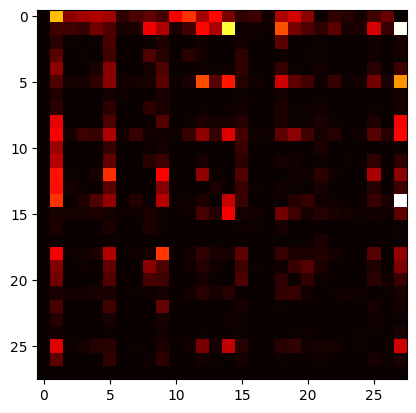

In [178]:
plt.imshow(frequencyTable, cmap='hot', interpolation='nearest')

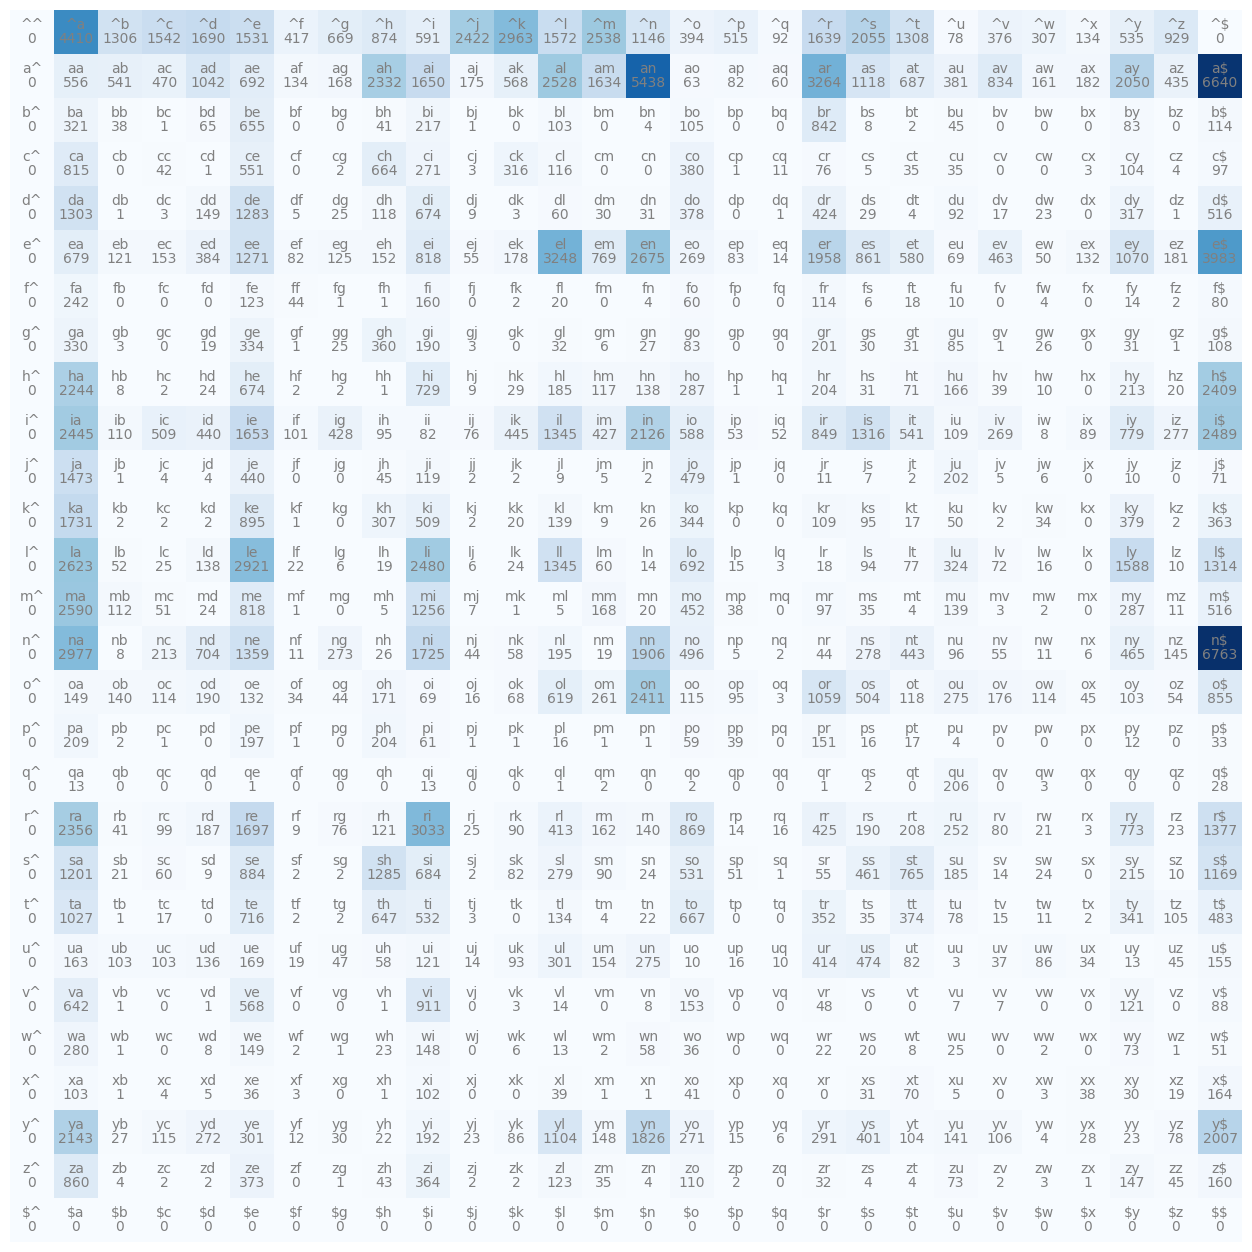

In [179]:
def showBigramHeatmap(counts, vocabulary):
    plt.figure(figsize=(16,16))
    plt.imshow(counts, cmap='Blues')
    for r in range(len(vocabulary)):
        for c in range(len(vocabulary)):
            chstr = itoc[r] + itoc[c]
            if (chstr == '$$'):
                chstr = '\$\$'
            plt.text(c, r, chstr, ha='center', va='bottom', color='gray')
            plt.text(c, r, counts[r, c].item(), ha='center', va='top', color='gray')
    plt.axis('off')

showBigramHeatmap(frequencyTable, vocabulary)

Notice that there are redundant combinations in this dataset. We know that `a^` can never occur, for example, as `^` is the start character.

We have a whole column ending with `^` and a whole row starting with `$`. We can remove these rows and columns, as they are redundant. The only exception is the `^$` cell (the empty word), which we will keep. This means, however, that we can just use a single character to represent the start and end of a word.

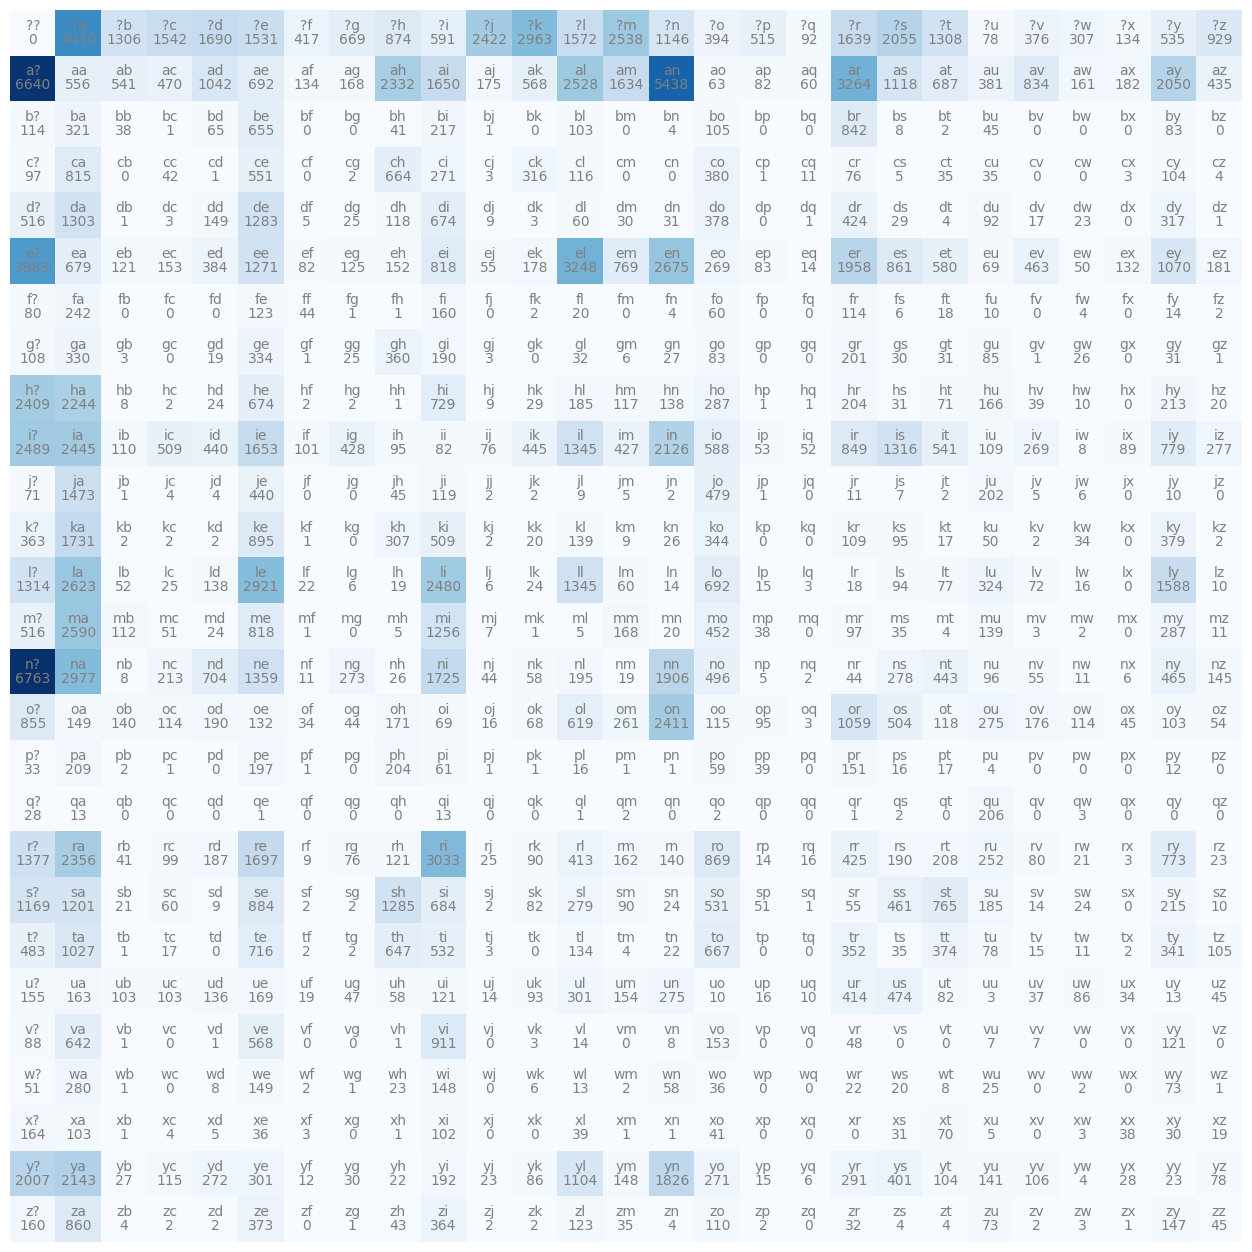

In [180]:
vocabulary = ['?'] + sorted(list(set(''.join(words))))
frequencyTable = torch.zeros(27, 27, dtype=torch.int32)

ctoi = { c: i for i, c in enumerate(vocabulary) }
itoc = { i: c for i, c in enumerate(vocabulary) }

# step through each character pair in the words
for word in words:

    characters = encode(['?'] + list(word) + ['?']) # hallucinate start and end characters
        
    for bigramIndexes in zip(characters, characters[1:]):
        frequencyTable[bigramIndexes] += 1 # increment the count of the bigram

showBigramHeatmap(frequencyTable, vocabulary)

### Sampling

We need to convert these counts into probabilities. We can do this via normalisation; dividing each row by the sum of the row, such that the sum of each row is 1.

#### Normalisation

In [181]:
rowProbabilities = frequencyTable[0].float()
rowProbabilities /= rowProbabilities.sum() # normalise the probabilities

print(rowProbabilities)
print(rowProbabilities.sum())

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
tensor(1.)


In [182]:
probabilityTable = frequencyTable.float()
probabilityTable /= probabilityTable.sum(dim=1, keepdim=True) # normalise the probabilities
# divide each value in the table by the summation of its row (dimension = 1)

print((probabilityTable[0] == rowProbabilities).all())

tensor(True)


#### Multinomial



In [183]:
probabilities = torch.rand(3, generator=generator)
probabilities /= probabilities.sum()
# this array holds the probability of its index being drawn from the multinomial distribution
# i.e. ~40% chance of 0, ~42% chance of 1, ~18% chance of 2
print(probabilities)

temp = torch.multinomial(probabilities, num_samples=20, replacement=True, generator=generator)
# this array holds the specified number of samples drawn from the multinomial distribution
print(temp)

tensor([0.4047, 0.4197, 0.1756])
tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2])


In [184]:
rowProbabilities = probabilityTable[1] # 'a'
indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
# sample a single index from the first row, using the multinomial distribution
# multiple samples can be drawn at once, by increasing the num_samples parameter
# this returns the index of the sampled value (aka the prediciton of what the next character will be)

# under the hood, the multinomial function is just drawing a random number,
# and then using the probabilities to determine which index the random number corresponds to

print(indexes)
print(decode([indexes]))
# likely this will predict that the next character is 'n'

14
n


### Using the Model

1. We can simply feed `?` into the model.
2. We then append the predicted character to a string, and feed this new character back into the model.
3. We repeat this process until we recieve a `?` as the output. This is the end of the word.

Et, voila.

In [185]:
newName = [ctoi['?']]

while (newName[-1] != ctoi['?'] or len(newName) == 1):

    lastChar = newName[-1]
    rowProbabilities = frequencyTable[lastChar].float()

    indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
    newName.append(indexes)

print(decode(newName[1:-1])) # trim the start and end characters, and convert to a string

bellyamiiae


### Uniform Distribution
(An untrained model, using pure random probability to genearate a sequence, for comparison)

In [186]:
newName = [ctoi['?']]

while (newName[-1] != ctoi['?'] or len(newName) == 1):

    lastChar = newName[-1]
    rowProbabilities = torch.ones(27) / 27.0

    indexes = torch.multinomial(rowProbabilities, num_samples=1, replacement=True, generator=generator).item()
    newName.append(indexes)

print(decode(newName[1:-1])) # trim the start and end characters, and convert to a string

ybkejmszqsqgtoyzjovtkimpupooznnyzujfosjvslrumxtonaclpgcyaqxknvzioiuqrtensqvgsumjqwqeioionyyrmnyctrjzdwtyazxdbpnftaauzyskakoth
